Topic 0 (Joy/Optimism): terrorism dont say fear terror life terrible worry make thing
Topic 1 (Joy/Optimism): dark little another service amp horror sober thanks doesnt awful
Topic 2 (Joy/Optimism): fuck need people boiling love get birthday wrath happy im
Topic 3 (Joy/Optimism): hope shake oh snap get im think time hilarious nightmare
Topic 4 (Joy/Optimism): dull first im thats would half mourn blue get shocking
Topic 5 (Joy/Optimism): people musically broadcast anxiety feel horrible watch amazing depression lively
Topic 6 (Joy/Optimism): furious truth sorry im know nervous like sadness lost dont
Topic 7 (Joy/Optimism): love start home awe looking look gbbo god pout revenge
Topic 8 (Joy/Optimism): go bully anger im youre unhappy fucking fury day sadly
Topic 9 (Joy/Optimism): depressing back offend angry heart part im great let fuming


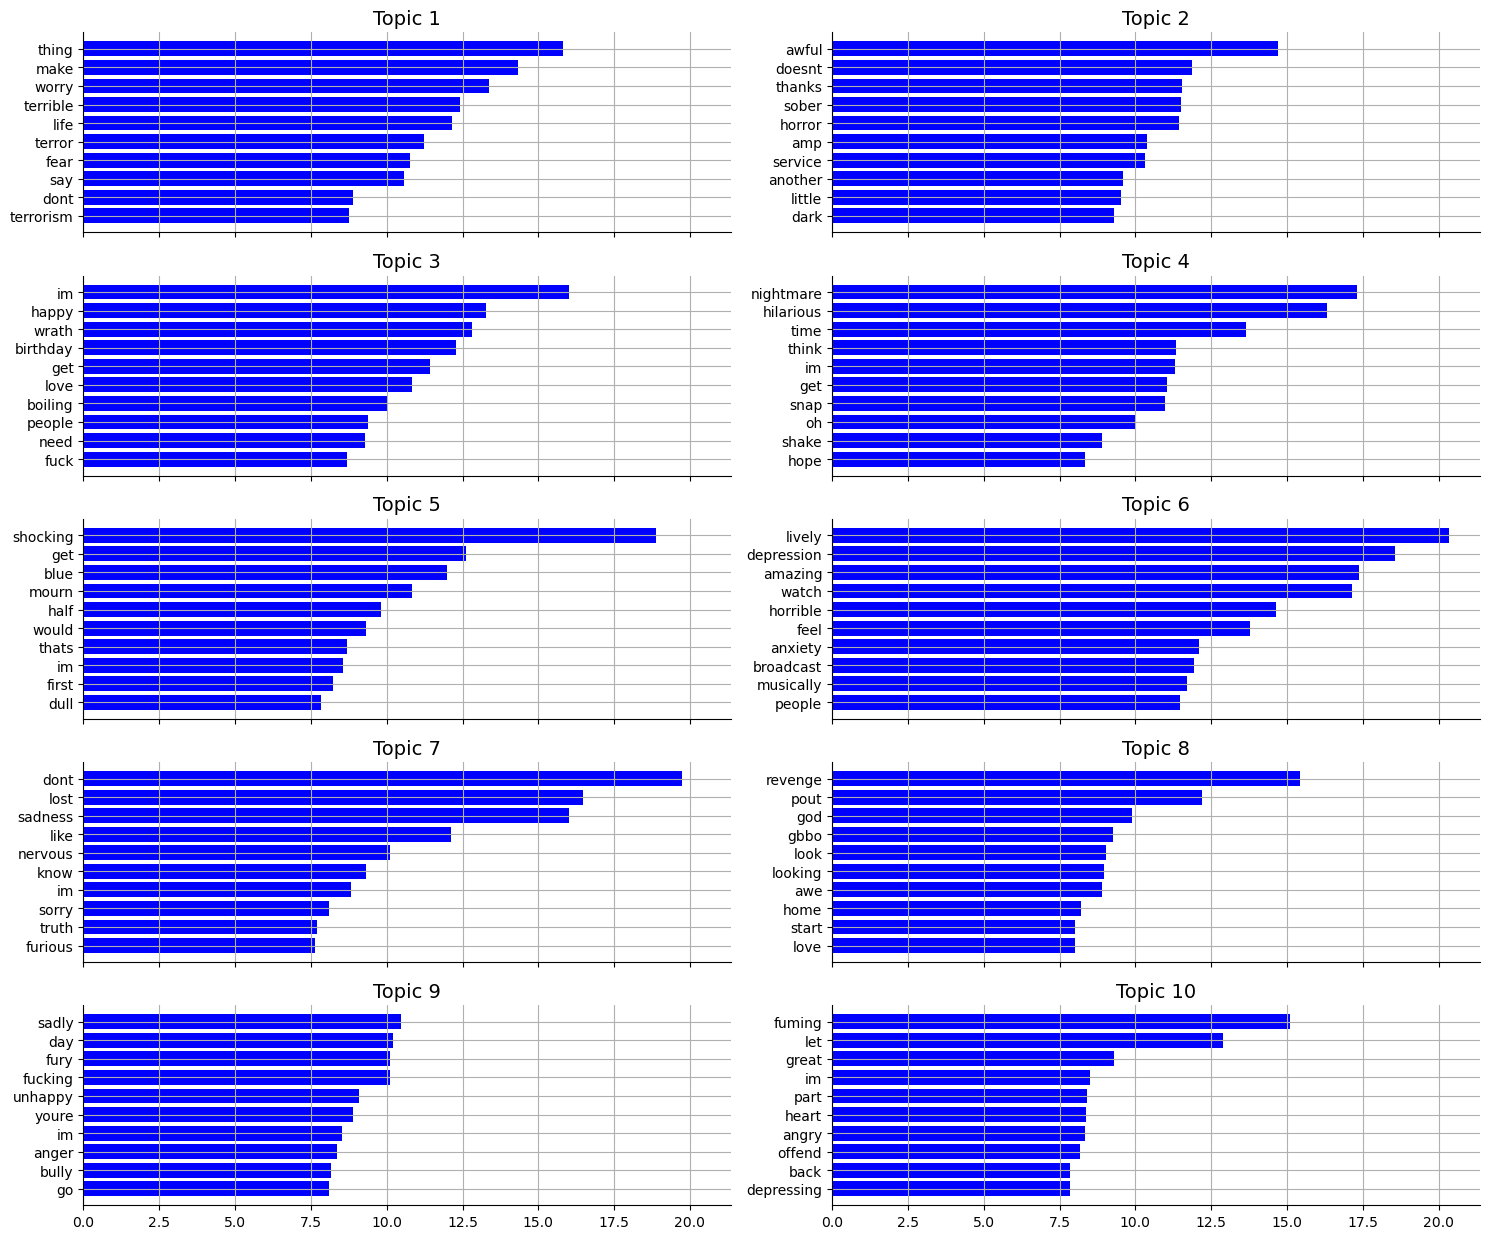

In [10]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
import seaborn as sns

# Read Parquet files
train_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\train.parquet')
val_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\validation.parquet')
test_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\test.parquet')

# Merge training and validation datasets
combined_dataframe = pd.concat([train_dataframe, val_dataframe])

# Custom text cleaning and preprocessing class
class TextPreprocessor(TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
        text = text.lower()
        text = ' '.join([self.lemmatizer.lemmatize(word) for word in text.split() if word not in self.stop_words])
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clean_text(text) for text in X]

# Create a data preprocessing and LDA modeling pipeline
pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor()),
    ('tfidf_vectorizer', TfidfVectorizer(max_features=1000)),  # Limit the number of features to optimize performance
    ('lda', LDA(n_components=10, random_state=42))  # n_components is the number of topics
])

# Apply preprocessing and topic modeling
combined_features = pipeline.fit_transform(combined_dataframe['text'])
test_features = pipeline.transform(test_dataframe['text'])

# Get indices of texts related to joy and optimism
joy_indices = combined_dataframe[combined_dataframe['label'] == 1].index
optimism_indices = combined_dataframe[combined_dataframe['label'] == 2].index

for topic_idx, topic in enumerate(pipeline.named_steps['lda'].components_):
    top_features = [feature_names[i] for i in topic.argsort()[-10:]]  # Get the top 10 features with the highest weights for each topic
    # Print topics related to joy or optimism only
    joy_topic_relevance = np.sum(combined_features[joy_indices][:, topic_idx])
    optimism_topic_relevance = np.sum(combined_features[optimism_indices][:, topic_idx])
    if joy_topic_relevance > 0 or optimism_topic_relevance > 0:  # Check if there is significant topic contribution in these indices
        print(f"Topic {topic_idx} (Joy/Optimism): {' '.join(top_features)}")


def plot_top_words(model, feature_names, n_top_words, n_topics):
    fig, axes = plt.subplots(int(n_topics / 2), 2, figsize=(15, 2.5 * int(n_topics / 2)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[:n_topics]):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, color='blue')
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=14)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right'.split():
            ax.spines[i].set_visible(False)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot bar charts
n_top_words = 10
n_topics = 10  # Adjust according to the n_components set in your LDA model
plot_top_words(pipeline.named_steps['lda'], feature_names, n_top_words, n_topics)
